# Histogram Equalization

In [82]:
%matplotlib inline 

from scipy import ndimage
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt

Here's the image we'll be equalizing. Notice the lower light near the bottom and the higher light near the top.

(674, 500, 3)


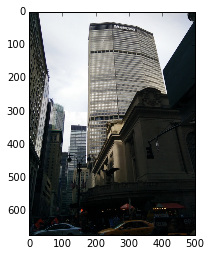

In [83]:
f = ndimage.imread("ny.jpg")
plt.imshow(f)

dims = f.shape
print dims

## Standard Histogram Equalization
Let's define the equalization function

In [88]:
#array must be sorted
def scale(arr, rmin, rmax):
    dmax = float(arr[-1])
    dmin = float(arr[0])
    
    drange = dmax-dmin
    rrange = rmax-rmin
    return map(lambda x: int(((x-dmin)/drange)*rrange + rmin), arr)
    

In [89]:
channels = []
for i in range(3):
    channels.append(f[:,:,i])

hist = map(lambda channel: ndimage.measurements.histogram(channel, 0, 255, 256), channels)

In [90]:
cum = map(lambda h: [], hist)
sums = map(lambda h: 0, hist)
for i in range(256):
    for j in range(3):
        cum[j].append(sums[j])
        sums[j] += hist[j][i]

cum = map(lambda cumi: scale(cumi, 0., 255.), cum)

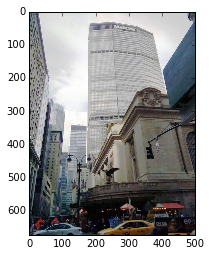

In [96]:
g = np.ndarray.copy(f)
for i in range(dims[0]):
    for j in range(dims[1]):
        for k in range(dims[2]):
            g[i,j,k] = cum[k][g[i,j,k]]

plt.imshow(g)

## Locally Adaptive Histogram Equalization

* wrap histogram generation into function
* call on block sections of image (corner gets 4 blocks)
* use grid of histograms to organiz